In [1]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

Cloning into 'Financial_Sentiment_LLM'...
remote: Enumerating objects: 2242, done.
remote: Counting objects: 100% (647/647), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 2242 (delta 406), reused 585 (delta 352), pack-reused 1595
Receiving objects: 100% (2242/2242), 483.80 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (1489/1489), done.
Updating files: 100% (1158/1158), done.


In [3]:
# Load prepped data
gemini_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/04_Stock_Modeling/02_Gemini_Prepped_Stock_Data.csv')
print(gemini_sentiment.shape)
display(gemini_sentiment.head())
print(gemini_sentiment.isna().sum())

(9585, 12)


,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Returns
0,Earnings Call Presentations,EP-331,BP,2019-02-05,NaN,Positive,Positive,Positive,Positive,Positive,Neutral,0.034550
1,Earnings Call Q&A,EQ-331,BP,2019-02-05,NaN,Positive,Positive,Positive,Positive,Positive,Neutral,0.034550
2,Investment Research,IR-4891,BP,2019-02-20,NaN,Positive,Positive,Neutral,Neutral,Neutral,Neutral,0.002359
3,Earnings Call Presentations,EP-317,BP,2019-04-30,NaN,Positive,Positive,Positive,Neutral,Positive,Neutral,0.016503
4,Earnings Call Q&A,EQ-317,BP,2019-04-30,NaN,Positive,Positive,Positive,Positive,Positive,Neutral,0.016503


Source             0
Unique_ID          0
Ticker             0
Date               0
URL             4887
Finance            0
Production         0
Reserves/M&A       0
Regulatory         0
Green Energy       0
OG Price           0
Returns            0
dtype: int64


In [4]:
# Drop extra columns
gemini_sentiment = gemini_sentiment.drop(['Unique_ID','URL'], axis=1)

# Convert the 'Date' column to datetime
gemini_sentiment['Date'] = pd.to_datetime(gemini_sentiment['Date'])
display(gemini_sentiment.head())

,Source,Ticker,Date,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Returns
0,Earnings Call Presentations,BP,2019-02-05,Positive,Positive,Positive,Positive,Positive,Neutral,0.034550
1,Earnings Call Q&A,BP,2019-02-05,Positive,Positive,Positive,Positive,Positive,Neutral,0.034550
2,Investment Research,BP,2019-02-20,Positive,Positive,Neutral,Neutral,Neutral,Neutral,0.002359
3,Earnings Call Presentations,BP,2019-04-30,Positive,Positive,Positive,Neutral,Positive,Neutral,0.016503
4,Earnings Call Q&A,BP,2019-04-30,Positive,Positive,Positive,Positive,Positive,Neutral,0.016503


In [5]:
# One hot encode categorical variables
gemini_sentiment_encoded = pd.get_dummies(gemini_sentiment, columns=['Ticker',
                                                                     'Source',
                                                                     'Finance',
                                                                     'Production',
                                                                     'Reserves/M&A',
                                                                     'Regulatory',
                                                                     'Green Energy',
                                                                     'OG Price'], drop_first=True)
display(gemini_sentiment_encoded.head())

,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
0,2019-02-05,0.034550,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
1,2019-02-05,0.034550,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
2,2019-02-20,0.002359,False,False,False,False,False,False,False,False,...,False,True,True,False,True,False,True,False,True,False
3,2019-04-30,0.016503,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,False,True,True,False
4,2019-04-30,0.016503,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False


In [7]:
# Split into test and train
split_date = pd.to_datetime('2024-01-01')

# Split the DataFrame
train_df = gemini_sentiment_encoded[(gemini_sentiment_encoded['Date'] < split_date)]
test_df = gemini_sentiment_encoded[gemini_sentiment_encoded['Date'] >= split_date]

display(train_df.tail())
display(test_df.head())

,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
9509,2023-12-13,0.008873,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
9510,2023-12-16,-0.016701,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,False,True,True,False
9511,2023-12-20,-0.016701,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
9512,2023-12-23,-0.012386,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,False,True,True,False
9513,2023-12-30,-0.012386,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,False,True,True,False


,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
752,2024-01-02,0.002825,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
753,2024-01-02,0.002825,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
754,2024-01-09,-0.015241,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
755,2024-01-11,-0.002594,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
756,2024-01-13,-0.016638,False,False,False,False,False,False,False,False,...,True,False,False,True,True,False,False,True,True,False


In [8]:
# Define X and y
X_train = train_df.drop(columns=['Date','Returns'])
X_test = test_df.drop(columns=['Date','Returns'])

y_train = train_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)
y_test = test_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)

print(len(X_train), len(y_train), len(X_test), len(y_test))
display(X_train.head())
display(y_train.head())

9050 9050 535 535


,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,Ticker_PSX,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,True,False,True,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,False,True,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False


0    1
1    1
2    1
3    1
4    1
Name: Returns, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.45      0.48       261
           1       0.53      0.58      0.55       274

    accuracy                           0.52       535
   macro avg       0.52      0.52      0.52       535
weighted avg       0.52      0.52      0.52       535



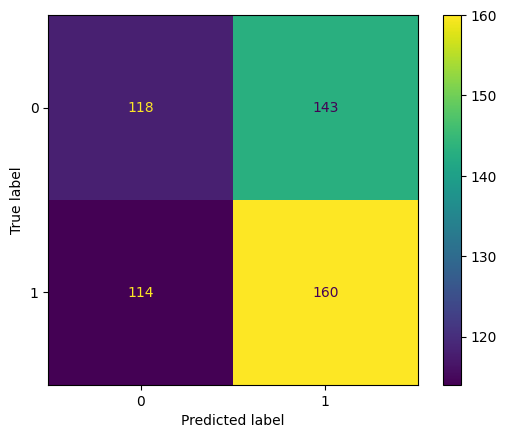

In [9]:
# Baseline XGBoost
XGB = XGBClassifier(random_state=42)
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(XGB, X_test, y_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'eta': 0.01, 'max_depth': 1, 'n_estimators': 25}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       261
           1       0.51      1.00      0.68       274

    accuracy                           0.51       535
   macro avg       0.26      0.50      0.34       535
weighted avg       0.26      0.51      0.35       535



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


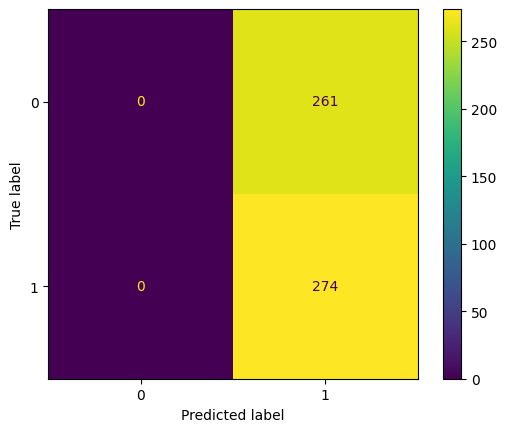

In [10]:
# Tuned XGBoost

# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [1, 3, 6, 9]
}

# Create an XGBoost classifier
XGB = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGB, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

# Make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [11]:
# Since dates can have multiple articles and therefore multiple predictions, we can
# pick the result with the highest probability.  This might be important for the next steps,
# but currently this is just a placeholder

# Predict probabilities and classes
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# Create a DataFrame with the results
results_df = pd.DataFrame(X_test, columns=X_test.columns)
results_df['Actual'] = y_test
results_df['Predicted_Class'] = y_pred
results_df['Predicted_Probability_Class_0'] = y_pred_proba[:, 0]
results_df['Predicted_Probability_Class_1'] = y_pred_proba[:, 1]
display(results_df.head())

,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,Ticker_PSX,...,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive,Actual,Predicted_Class,Predicted_Probability_Class_0,Predicted_Probability_Class_1
752,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,1,1,0.481256,0.518744
753,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,1,1,0.482204,0.517796
754,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,0,1,0.482204,0.517796
755,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,0,1,0.482204,0.517796
756,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,True,False,0,1,0.481256,0.518744
